In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "5 parts_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 10, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        test_size = int(test_ratio * len(dataset))
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
        trainloader_transfer.append(DataLoader(train_dataset_transfer, batch_size=batch_size, shuffle=True))
        valloader_transfer.append(DataLoader(val_dataset_transfer, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)


In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
torch.Size([936, 4, 50])
(1560, 4, 50)
torch.Size([1242, 4, 50])
(2070, 4, 50)
torch.Size([1014, 4, 50])
(1690, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 49.1788330078125 Testing accuracy: 54.74452590942383.

Epoch 2/100
Epoch 2: Training accuracy: 54.105838775634766 Testing accuracy: 50.36496353149414.

Epoch 3/100
Epoch 3: Training accuracy: 62.68247985839844 Testing accuracy: 60.58394241333008.

Epoch 4/100
Epoch 4: Training accuracy: 66.69708251953125 Testing accuracy: 69.34306335449219.

Epoch 5/100
Epoch 5: Training accuracy: 68.0656967163086 Testing accuracy: 71.53284454345703.

Epoch 6/100
Epoch 6: Training accuracy: 68.8868637084961 Testing accuracy: 68.6131362915039.

Epoch 7/100
Epoch 7: Training accuracy: 68.52189636230469 Testing accuracy: 72.9926986694336.

Epoch 8/100
Epoch 8: Training accuracy: 69.52555084228516 Testing accuracy: 70.80291748046875.

Epoch 9/100
Epoch 9: Training accuracy: 69.16058349609375 Testing accuracy: 70.80291748046875.

Epoch 10/100
Epoch 10: Training accuracy: 69.52555084228516 Testing accuracy: 71.53284454345703.

Epoch 11/100
Epoch 11: Training accuracy:

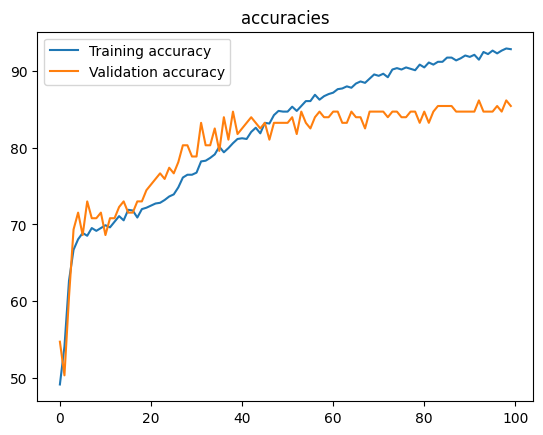

Exception ignored in atexit callback: <function _Manager._atexit_setup.<locals>.<lambda> at 0x7f57f52641f0>
Traceback (most recent call last):
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/wandb_manager.py", line 175, in <lambda>
    self._atexit_lambda = lambda: self._atexit_teardown()
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/wandb_manager.py", line 189, in _atexit_teardown
    self._teardown(self._hooks.exit_code if self._hooks else 0)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/wandb_manager.py", line 170, in _teardown
    return self._service.join()
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/service/service.py", line 266, in join
    ret = self._internal_proc.wait()
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/subprocess.py", line 1204, in wait
    return self._wait(timeout=timeout)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/s

In [8]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning

For client 1

Epoch 1/100
Epoch 1: Training accuracy: 51.646705627441406 Testing accuracy: 50.8982048034668.

Epoch 2/100
Epoch 2: Training accuracy: 64.2215576171875 Testing accuracy: 68.86227416992188.

Epoch 3/100
Epoch 3: Training accuracy: 66.99102020263672 Testing accuracy: 68.26347351074219.

Epoch 4/100
Epoch 4: Training accuracy: 68.33832550048828 Testing accuracy: 69.46107482910156.

Epoch 5/100
Epoch 5: Training accuracy: 69.61077880859375 Testing accuracy: 67.6646728515625.

Epoch 6/100
Epoch 6: Training accuracy: 71.1077880859375 Testing accuracy: 67.06586456298828.

Epoch 7/100
Epoch 7: Training accuracy: 70.80838012695312 Testing accuracy: 68.86227416992188.

Epoch 8/100
Epoch 8: Training accuracy: 72.15568542480469 Testing accuracy: 70.65868377685547.

Epoch 9/100
Epoch 9: Training accuracy: 73.87724304199219 Testing accuracy: 73.05389404296875.

Epoch 10/100
Epoch 10: Training accuracy: 75.67365264892578 Testing accuracy: 73.65269470214844.

Epoch 11/100
Epoch 11: Trai

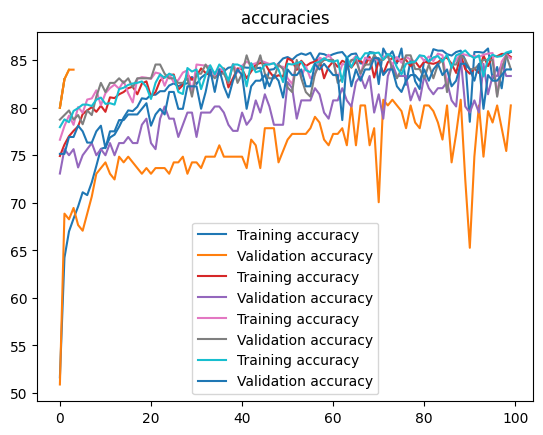

In [8]:
losses = []
accuracies = []
transfer_set = zip(azure_train_loaders_transfer, azure_val_loaders)
i = 1
for c_train, c_val in transfer_set:
    print(f"For client {i}")
    for epoch in range(1):
        train(net, c_train, c_val, configuration, configuration['epochs'])
        loss, accuracy = test(net, c_val, configuration)
        losses.append(loss)
        accuracies.append(int(accuracy))
        print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
    plt.plot(accuracies)
    loss, accuracy = test(net, testloader, configuration=configuration)
    i += 1

    print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [12]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-08-11 23:27:04,900	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'object_store_memory': 58436315136.0, 'node:__internal_head__': 1.0, 'GPU': 2.0, 'accelerator_type:G': 1.0, 'node:192.168.1.146': 1.0, 'memory': 126351401984.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.06378086588599464 / accuracy 47.78254699707031
(ClientAppActor pid=2099392) 
(ClientAppActor pid=2099392) Epoch 1/100
(ClientAppActor pid=2099393) Epoch 1: Training accuracy: 50.664249420166016 Testing accuracy: 50.241546630859375.
(ClientAppActor pid=2099392)  [repeated 372x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2099392) Epoch 99/100 [repeated 372x across cluster]
(ClientAppActor pid=2099392) Epoch 100: Training accuracy: 56.43712615966797 Testing accuracy: 55.089820861816406. [repeated 376x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.06179181012240323, {'accuracy': tensor(71.1016, device='cuda:0')}, 6.822098092059605)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.06179181012240323 / accuracy 71.10157012939453
(ClientAppActor pid=2099392)  [repeated 365x across cluster]
(ClientAppActor pid=2099392) Epoch 82/100 [repeated 365x across cluster]
(ClientAppActor pid=2099392) Epoch 85: Training accuracy: 70.35928344726562 Testing accuracy: 70.05988311767578. [repeated 367x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.059706790880723434, {'accuracy': tensor(73.2475, device='cuda:0')}, 12.372817235067487)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.059706790880723434 / accuracy 73.24749755859375
(ClientAppActor pid=2099392)  [repeated 375x across cluster]
(ClientAppActor pid=2099392) Epoch 58/100 [repeated 375x across cluster]
(ClientAppActor pid=2099392) Epoch 60: Training accuracy: 74.75845336914062 Testing accuracy: 74.39613342285156. [repeated 374x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.05659010193564675, {'accuracy': tensor(74.1059, device='cuda:0')}, 17.78335198306013)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05659010193564675 / accuracy 74.10586547851562
(ClientAppActor pid=2099392)  [repeated 371x across cluster]
(ClientAppActor pid=2099392) Epoch 37/100 [repeated 371x across cluster]
(ClientAppActor pid=2099392) Epoch 40: Training accuracy: 72.58454132080078 Testing accuracy: 71.98067474365234. [repeated 372x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.05600665916096081, {'accuracy': tensor(75.3934, device='cuda:0')}, 23.463835033006035)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05600665916096081 / accuracy 75.39341735839844
(ClientAppActor pid=2099392)  [repeated 359x across cluster]
(ClientAppActor pid=2099392) Epoch 21/100 [repeated 359x across cluster]
(ClientAppActor pid=2099392) Epoch 23: Training accuracy: 74.93961334228516 Testing accuracy: 73.4299545288086. [repeated 359x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.0545252724127336, {'accuracy': tensor(75.2504, device='cuda:0')}, 29.08049583097454)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0545252724127336 / accuracy 75.25035858154297
(ClientAppActor pid=2099392)  [repeated 371x across cluster]
(ClientAppActor pid=2099392) Epoch 13/100 [repeated 371x across cluster]
(ClientAppActor pid=2099392) Epoch 16: Training accuracy: 74.33432006835938 Testing accuracy: 73.3727798461914. [repeated 370x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.053598338907415215, {'accuracy': tensor(73.6767, device='cuda:0')}, 34.755139596993104)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.053598338907415215 / accuracy 73.67668151855469
(ClientAppActor pid=2099392)  [repeated 330x across cluster]
(ClientAppActor pid=2099392) Epoch 68/100 [repeated 330x across cluster]
(ClientAppActor pid=2099392) Epoch 71: Training accuracy: 76.93236541748047 Testing accuracy: 76.81159210205078. [repeated 331x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.05361515283584595, {'accuracy': tensor(75.2504, device='cuda:0')}, 40.21046165598091)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05361515283584595 / accuracy 75.25035858154297
(ClientAppActor pid=2099392)  [repeated 375x across cluster]
(ClientAppActor pid=2099392) Epoch 57/100 [repeated 375x across cluster]
(ClientAppActor pid=2099392) Epoch 59: Training accuracy: 76.99275207519531 Testing accuracy: 76.81159210205078. [repeated 374x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.052807060155001556, {'accuracy': tensor(75.3934, device='cuda:0')}, 45.649042055010796)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.052807060155001556 / accuracy 75.39341735839844
(ClientAppActor pid=2099392)  [repeated 374x across cluster]
(ClientAppActor pid=2099392) Epoch 55/100 [repeated 374x across cluster]
(ClientAppActor pid=2099392) Epoch 59: Training accuracy: 74.67948913574219 Testing accuracy: 73.07691955566406. [repeated 376x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.053235986016013405, {'accuracy': tensor(76.5379, device='cuda:0')}, 51.31927201000508)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.053235986016013405 / accuracy 76.53791046142578
(ClientAppActor pid=2099392)  [repeated 350x across cluster]
(ClientAppActor pid=2099392) Epoch 26/100 [repeated 350x across cluster]
(ClientAppActor pid=2099392) Epoch 29: Training accuracy: 74.77810668945312 Testing accuracy: 74.55621337890625. [repeated 348x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.05236772515557029, {'accuracy': tensor(75.6795, device='cuda:0')}, 57.09930385102052)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 rounds in 57.12s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.22544950246810913\n'
INFO :      	 '\tround 2: 0.20831609765688577\n'
INFO :      	 '\tround 3: 0.20556939641634622\n'
INFO :      	 '\tround 4: 0.15669782672609603\n'
INFO :      	 '\tround 5: 0.19969009359677634\n'
INFO :      	 '\tround 6: 0.16156240020479476\n'
INFO :      	 '\tround 7: 0.19504482547442117\n'
INFO :      	 '\tround 8: 0.15429815224238805\n'
INFO :      	 '\tround 9: 0.14536373955862864\n'
INFO :      	 '\tround 10: 0.17670090993245444\n')History (loss, centralized):
INFO :      	('\tround 0: 0.063780865885994

Server-side evaluation loss 0.05236772515557029 / accuracy 75.6795425415039
(ClientAppActor pid=2099393) Epoch 99: Training accuracy: 75.29940032958984 Testing accuracy: 67.06586456298828.
(ClientAppActor pid=2099393) 
(ClientAppActor pid=2099393) Epoch 100/100
(ClientAppActor pid=2099393) Epoch 100: Training accuracy: 77.47006225585938 Testing accuracy: 74.25149536132812.


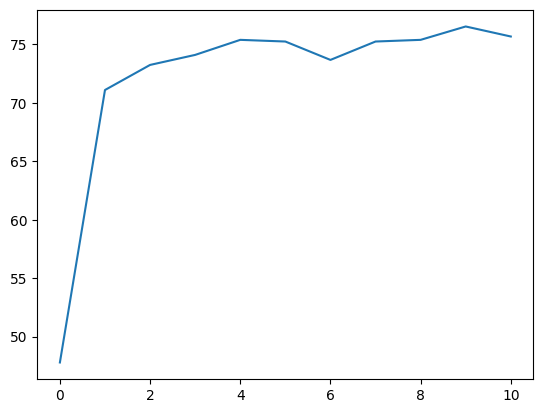

In [13]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)